In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
%matplotlib inline

In [528]:
# Assigning column names to the DataFrame 
columns = ['Year', 'Month', 'Fractional_Year', 'sunspot_number', 'std_dev', 'num_observations', 'def_prov_marker']
monthly_data = pd.read_csv("/Users/farhana/Downloads/Introduction to Data Science/Class Lectures/Projects/Project 3/SN_m_tot_V2.0.csv", sep=";", header=None, names=columns)
monthly_data.head()

,Year,Month,Fractional_Year,sunspot_number,std_dev,num_observations,def_prov_marker
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [529]:
# Keeping only the necessary columns
monthly_data = monthly_data[['Year', 'Month', 'sunspot_number']]

monthly_data.head()

,Year,Month,sunspot_number
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7


In [530]:
# Replacing -1 with NaN in the 'sunspot_number' column
monthly_data['sunspot_number'] = monthly_data['sunspot_number'].replace(-1, pd.NA)

print(monthly_data.isna().sum())

Year              0
Month             0
sunspot_number    0
dtype: int64


In [531]:
# Creating a 'date' column by combining 'Year' and 'Month'
monthly_data['date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(DAY=1))

# Setting the 'date' column as the index
monthly_data.set_index('date', inplace=True)
print(monthly_data.head())

            Year  Month  sunspot_number
date                                   
1749-01-01  1749      1            96.7
1749-02-01  1749      2           104.3
1749-03-01  1749      3           116.7
1749-04-01  1749      4            92.8
1749-05-01  1749      5           141.7


In [532]:
# Using Forward fill missing values in the 'sunspot_number' column
monthly_data['sunspot_number'] = monthly_data['sunspot_number'].fillna(method='ffill')
print(monthly_data.isna().sum())

Year              0
Month             0
sunspot_number    0
dtype: int64


# Dustribution of Sunspot Number 

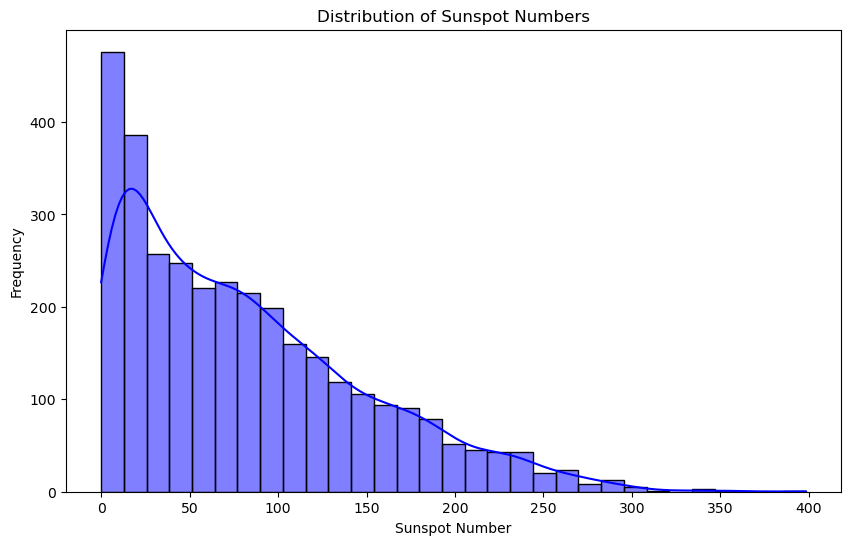

In [533]:
plt.figure(figsize=(10, 6))
sns.histplot(monthly_data['sunspot_number'], kde=True, color='blue')
plt.title('Distribution of Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.ylabel('Frequency')
plt.show()

# Sunspot Number Over Time 

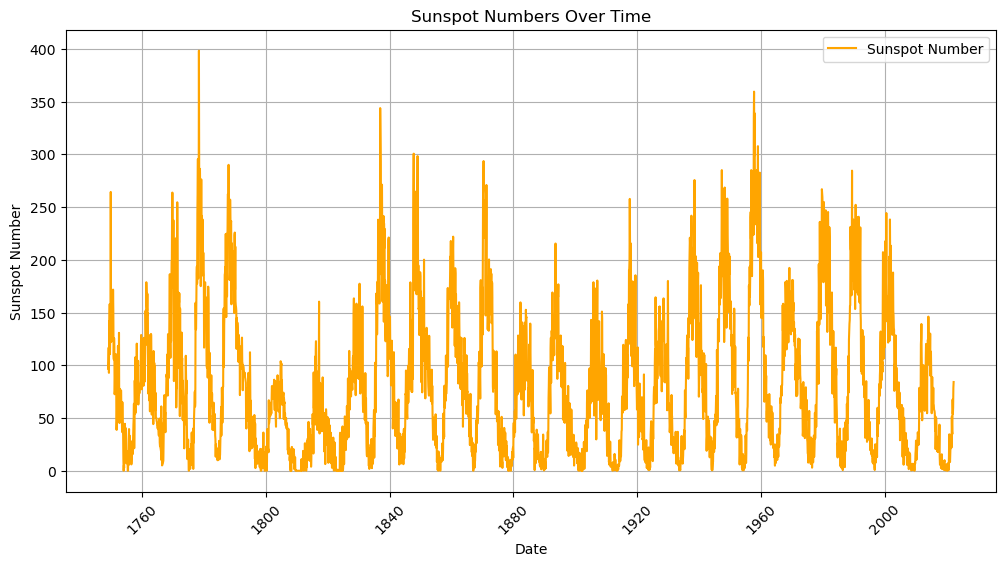

In [534]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['sunspot_number'], color='orange', label='Sunspot Number')
plt.title('Sunspot Numbers Over Time')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Sunspot numbers by year

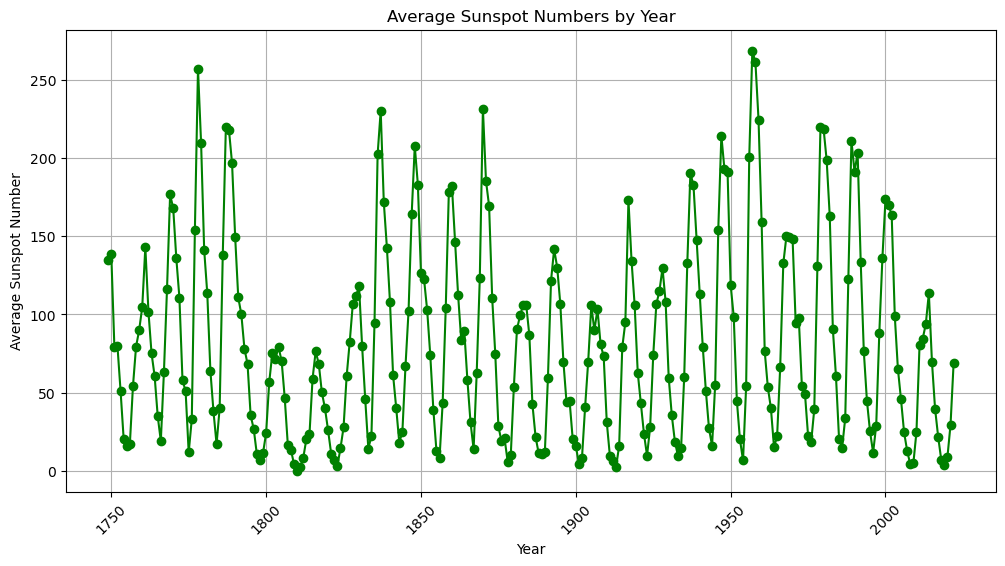

In [535]:
monthly_data['year'] = monthly_data.index.year
yearly_data = monthly_data.groupby('year')['sunspot_number'].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data, marker='o', color='green')
plt.title('Average Sunspot Numbers by Year')
plt.xlabel('Year')
plt.ylabel('Average Sunspot Number')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Boxplot to check for outliers

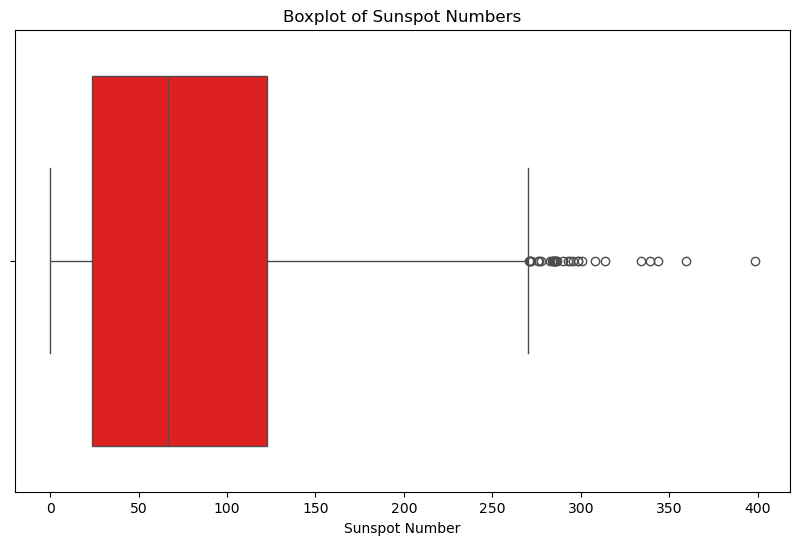

In [536]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=monthly_data['sunspot_number'], color='red')
plt.title('Boxplot of Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.show()

# Calculating 12 month rolling average

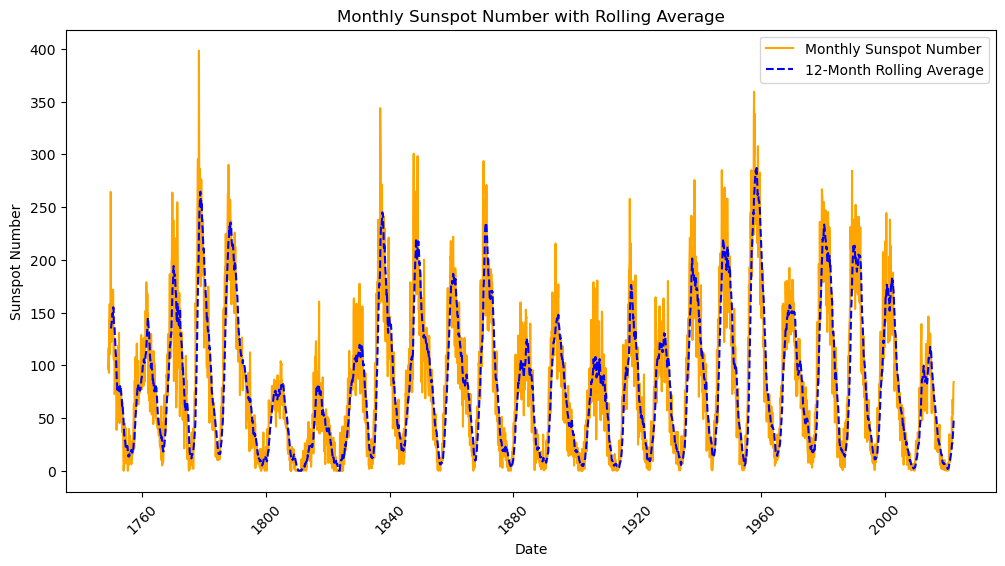

In [537]:
monthly_data['rolling_avg'] = monthly_data['sunspot_number'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['sunspot_number'], label='Monthly Sunspot Number', color='orange')
plt.plot(monthly_data.index, monthly_data['rolling_avg'], label='12-Month Rolling Average', color='blue', linestyle='--')
plt.title('Monthly Sunspot Number with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Heatmap of Sunspot Numbers By Month and Year

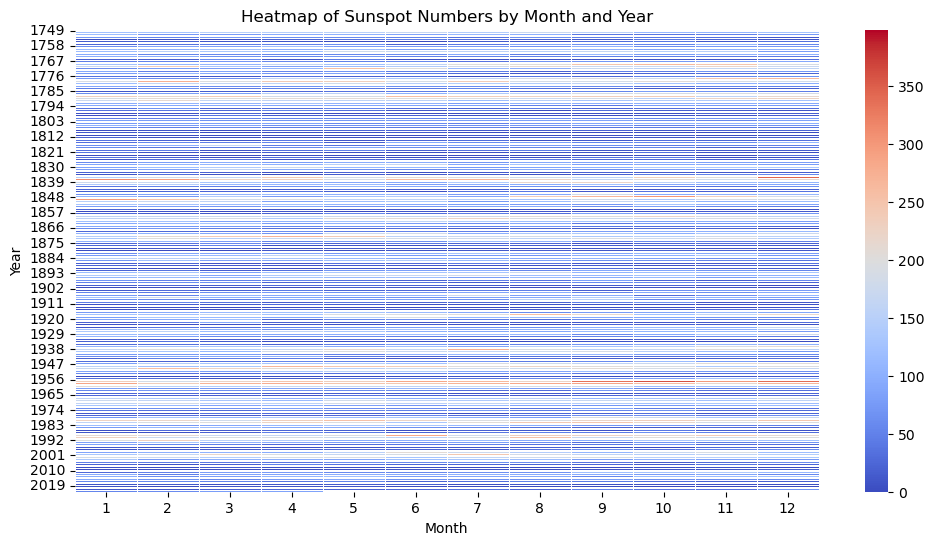

In [538]:
monthly_data['month'] = monthly_data.index.month
monthly_data['year'] = monthly_data.index.year

heatmap_data = monthly_data.pivot_table(index='year', columns='month', values='sunspot_number', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Heatmap of Sunspot Numbers by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [539]:
# Preparing the dataset for model training 
monthly_data = monthly_data.reset_index() 
monthly_data.rename(columns={'date': 'ds', 'sunspot_number': 'y'}, inplace=True)

print(monthly_data.head())

          ds  Year  Month      y  year  rolling_avg  month
0 1749-01-01  1749      1   96.7  1749          NaN      1
1 1749-02-01  1749      2  104.3  1749          NaN      2
2 1749-03-01  1749      3  116.7  1749          NaN      3
3 1749-04-01  1749      4   92.8  1749          NaN      4
4 1749-05-01  1749      5  141.7  1749          NaN      5


In [540]:
# Selecting only the 'ds' and 'y' columns
monthly_data = monthly_data[['ds', 'y']]
print(monthly_data.head())

          ds      y
0 1749-01-01   96.7
1 1749-02-01  104.3
2 1749-03-01  116.7
3 1749-04-01   92.8
4 1749-05-01  141.7


In [541]:
# Converting 'ds' to datetime 
monthly_data['ds'] = pd.to_datetime(monthly_data['ds'])
monthly_data['y'] = pd.to_numeric(monthly_data['y'], errors='coerce')
print(monthly_data.dtypes)

ds    datetime64[ns]
y            float64
dtype: object


In [542]:
train_size = int(len(monthly_data) * 0.8)
train_data = monthly_data[:train_size]
test_data = monthly_data[train_size:]

print(f'Training size: {len(train_data)}')
print(f'Test size: {len(test_data)}')

Training size: 2624
Test size: 656


In [543]:
Q1 = train_data['y'].quantile(0.25)
Q3 = train_data['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_data = train_data[(train_data['y'] > lower_bound) & (train_data['y'] < upper_bound)]

In [544]:
# Adding logistic growth limits (cap and floor)
train_data['cap'] = 0.95 * train_data['y'].max()  
train_data['floor'] = 0.05 * train_data['y'].min()

# Model Training

In [545]:
# Model Training 
model = Prophet(
    growth='logistic',  
    changepoint_prior_scale=0.03, 
    seasonality_prior_scale=20,  
    holidays_prior_scale=5,  
    seasonality_mode='multiplicative',  
    interval_width=0.95  
)

model.add_seasonality(
    name='monthly',
    period=30.5,  
    fourier_order=6  
)

model.add_seasonality(
    name='yearly',
    period=365.25,  
    fourier_order=10  
)

model.add_seasonality(
    name='quarterly',
    period=91, 
    fourier_order=4  
)

In [546]:
model.fit(train_data)

22:35:20 - cmdstanpy - INFO - Chain [1] start processing
22:35:20 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting with Prophet

In [547]:
# Creating the future dataframe based on the test data
df_future = model.make_future_dataframe(periods=len(test_data), freq='MS')

# Adding cap and floor for logistic growth
df_future['cap'] = 0.95 * train_data['y'].max()
df_future['floor'] = 1.05 * train_data['y'].min()

forecast = model.predict(df_future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
3228,2021-12-01,104.0,-10.0,216.0
3229,2022-01-01,110.0,-2.0,224.0
3230,2022-02-01,117.0,8.0,226.0
3231,2022-03-01,57.0,-57.0,169.0
3232,2022-04-01,78.0,-31.0,185.0


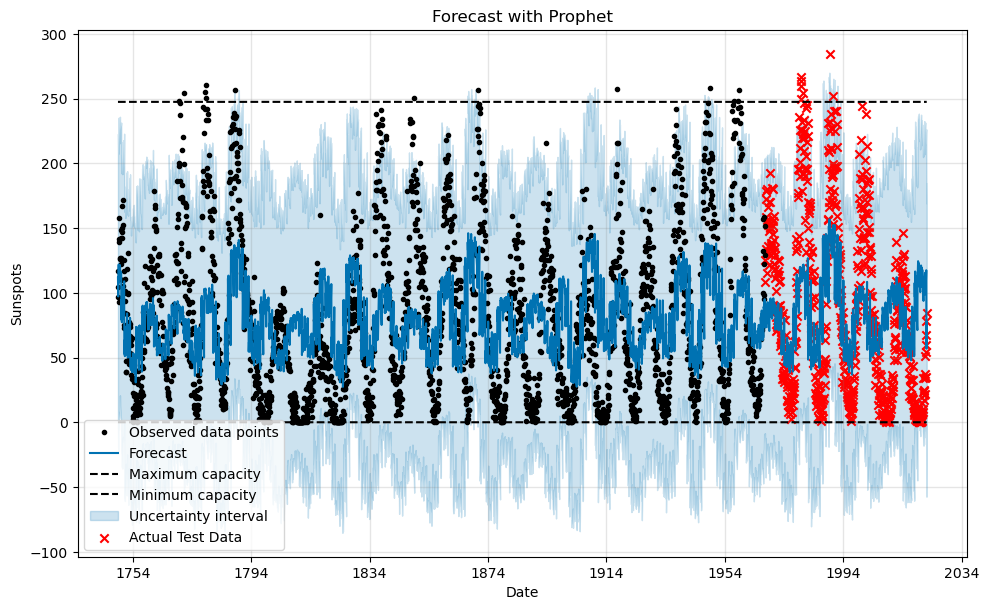

In [548]:
fig = model.plot(forecast)
plt.title('Forecast with Prophet')

plt.scatter(test_data['ds'], test_data['y'], color='red', label='Actual Test Data', marker='x')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.show()

# Model Evaluation

In [549]:
# Evaluating The Model
y_true = test_data['y'].values
y_pred = forecast['yhat'][-len(test_data):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r_squared = r2_score(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r_squared}")

RMSE: 62.708877216852066
MAE: 51.78461027478181
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.1808670669684046


/var/folders/zq/25twj4z91c95fby10kwlwmw80000gn/T/ipykernel_26943/1153642148.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
